# FRET analysis - FLIM

This is a script to analyze FRET from 2D FLIM  images of cells transfected with different force sensors.
As controls, we use a donor only construct.

All images were acquired on our FCS 1 photon confocal microscope.


This script is meant to analyze files in an automatic way (nuclei segmentation, mask detection for the NE area, fluorescence intensity measurements in different channels, formatting of data, graphical representation...

## Workflow

1. open files
2. segment cells - find bounding box
3. Life time analysis => create a mask on the NE
4. draw a histogram of the Donor lifetime - save mean and std
5. calculate nuclear shape index
6. save data along with metadata



This will already be a good start...

----

## Import libraries


In [1]:
%matplotlib inline


In [2]:
from readlif.reader import LifFile
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import skimage.filters
from skimage.io import imread, imshow
from skimage.morphology import area_opening
from skimage.exposure import histogram
from skimage.filters import threshold_otsu
import skimage.measure
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd

#from photutils.detection import DAOStarFinder
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.aperture import CircularAperture
from scipy import ndimage
from astropy.stats import sigma_clipped_stats
#from photutils.datasets import load_star_image
import os
from scipy.spatial.distance import canberra
from scipy.spatial.distance import pdist
import math
from itertools import combinations


import os
import seaborn as sns
from skimage import io, color


from segment_nuclear_envelope import NE_mask

---

## Define folders and load data


In [3]:
# Define folders
date = '240920'

InputFolder = '/Users/christine/Documents/Data/DynamoLINC/FLIM/FLIM_'+date+'/'
OutputFolder = '/Users/christine/Documents/Data/DynamoLINC/FLIM/FLIM_'+date+'/Results/'



ls = os.listdir(InputFolder+'FLIMdata/')
#ls.remove('TD-FLIM37.tif')

ls

['100um-1.tif',
 '100um-3.tif',
 '100um-2.tif',
 '100um-7.tif',
 '100um-5.tif',
 '100um-4.tif',
 '10um-8.tif',
 '10um-6.tif',
 '10um-7.tif',
 '10um-5.tif',
 '10um-4.tif',
 'square-1.tif',
 '10um-1.tif',
 '10um-3.tif',
 '10um-2.tif']

In [4]:
files=[]

for i in range(len(ls)):
    before, sep, after = ls[i].partition ('.')
    files.append(before)

In [5]:
files

['100um-1',
 '100um-3',
 '100um-2',
 '100um-7',
 '100um-5',
 '100um-4',
 '10um-8',
 '10um-6',
 '10um-7',
 '10um-5',
 '10um-4',
 'square-1',
 '10um-1',
 '10um-3',
 '10um-2']

In [6]:
# open FLIM file

for f in files:
    
## extract images 
    
    img_FLIM = io.imread(InputFolder+'FLIMdata/'+f+'.tif').astype(float)
    img_D = io.imread(InputFolder+f+'_Ch2.tif').astype(float)
    #img_FRET = io.imread(InputFolder+f+'_Ch1.tif').astype(float)
        

    fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2, figsize=(4,2), constrained_layout=True)
    flim=ax1.imshow(img_FLIM)
    ax1.set_title('FLIM')
    ax1.axis('off')
    
    don=ax0.imshow(img_D, cmap='gray')
    ax0.set_title('Donor')
    ax0.axis('off')
    
    fig.suptitle(f, fontsize=18)
    fig.colorbar(flim,ax=ax1)
    fig.colorbar(don,ax=ax0)
    plt.savefig(OutputFolder+f+'.tif')
    plt.close()
    plt.show()

print('Done !')



Done !


/var/folders/cs/qjl9__hn2ws3b7cm7jhy6c580000gn/T/ipykernel_3696/559421645.py:34: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(numerator / denominator1)
/var/folders/cs/qjl9__hn2ws3b7cm7jhy6c580000gn/T/ipykernel_3696/559421645.py:35: RuntimeWarning: invalid value encountered in sqrt
  b = np.sqrt(numerator / denominator2)


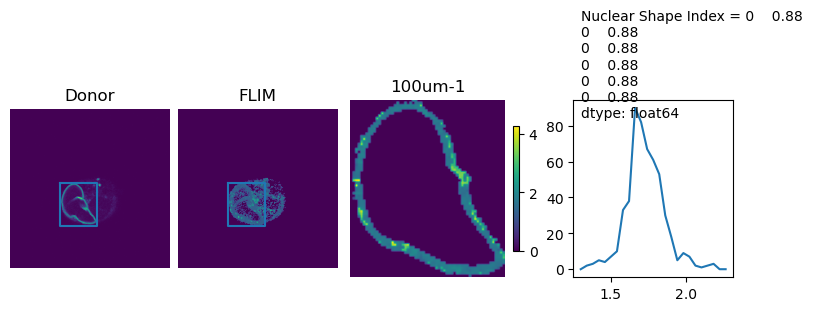

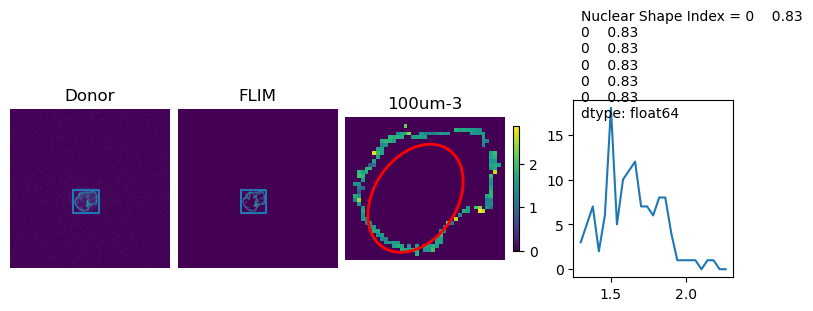

/var/folders/cs/qjl9__hn2ws3b7cm7jhy6c580000gn/T/ipykernel_3696/559421645.py:34: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(numerator / denominator1)
/var/folders/cs/qjl9__hn2ws3b7cm7jhy6c580000gn/T/ipykernel_3696/559421645.py:35: RuntimeWarning: invalid value encountered in sqrt
  b = np.sqrt(numerator / denominator2)


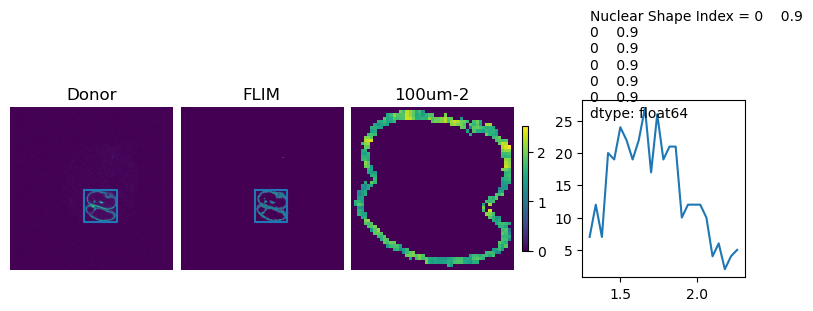

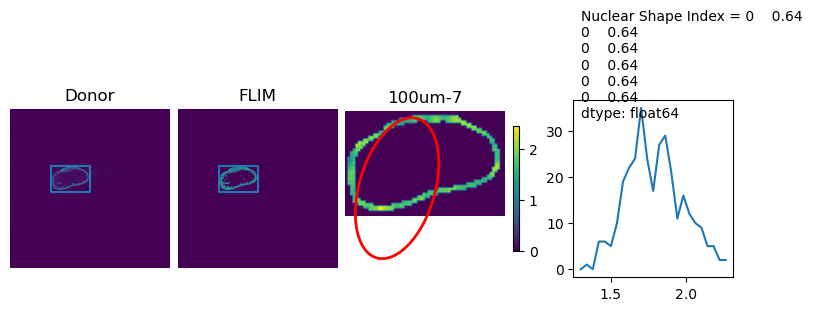

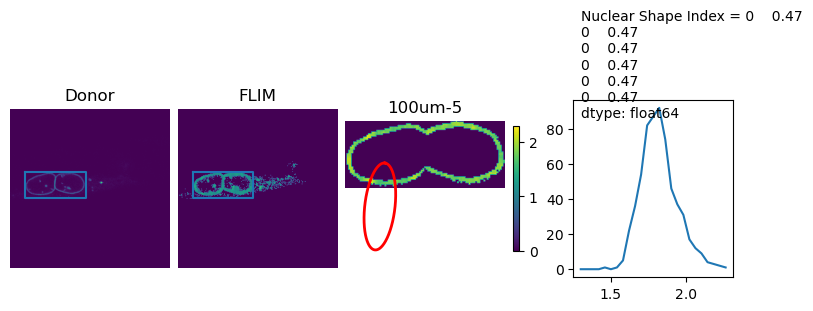

/var/folders/cs/qjl9__hn2ws3b7cm7jhy6c580000gn/T/ipykernel_3696/559421645.py:34: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(numerator / denominator1)
/var/folders/cs/qjl9__hn2ws3b7cm7jhy6c580000gn/T/ipykernel_3696/559421645.py:35: RuntimeWarning: invalid value encountered in sqrt
  b = np.sqrt(numerator / denominator2)


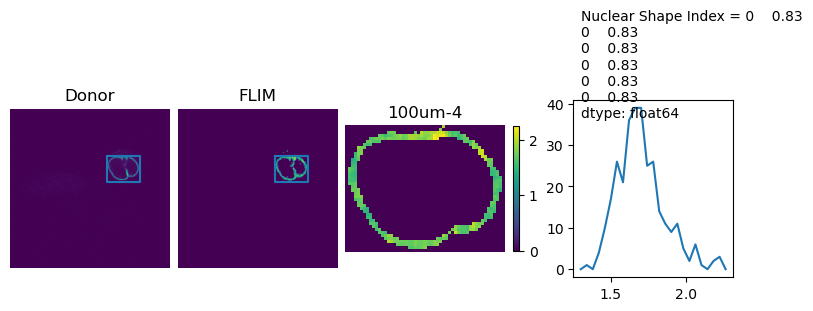

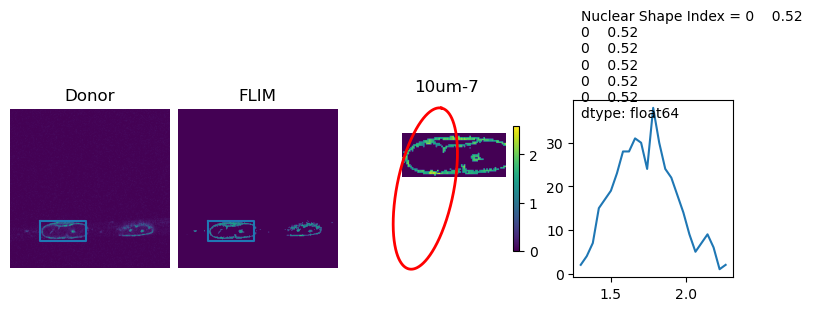

/var/folders/cs/qjl9__hn2ws3b7cm7jhy6c580000gn/T/ipykernel_3696/559421645.py:34: RuntimeWarning: invalid value encountered in sqrt
  a = np.sqrt(numerator / denominator1)
/var/folders/cs/qjl9__hn2ws3b7cm7jhy6c580000gn/T/ipykernel_3696/559421645.py:35: RuntimeWarning: invalid value encountered in sqrt
  b = np.sqrt(numerator / denominator2)


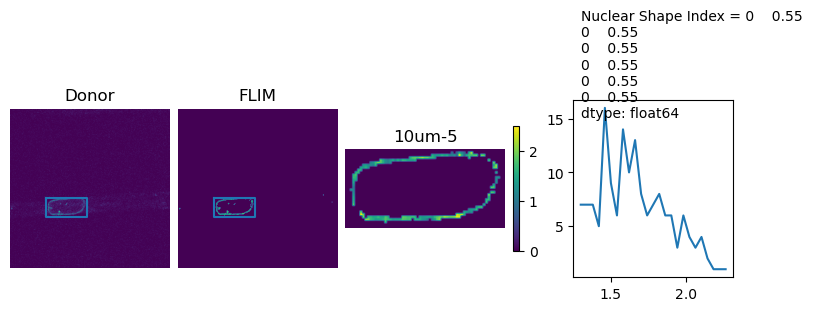

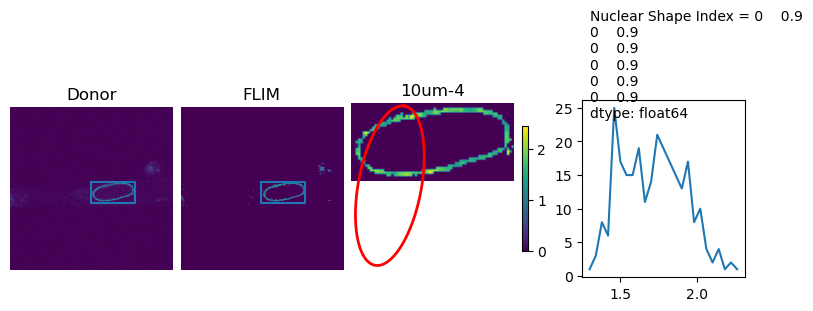

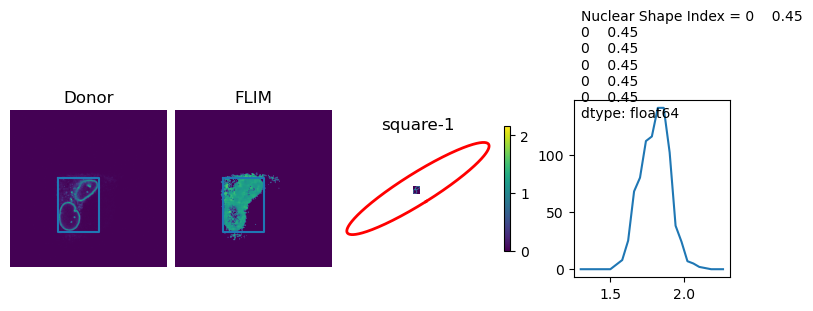

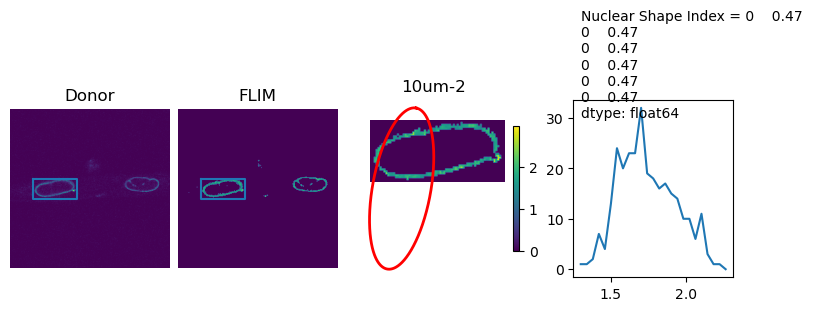

Done !


In [264]:
from numpy.ma import masked_values

minval = 1.3
maxval = 2.3
b=25

hist = []
names = []
cond = []
nucl_index = []
mean_tau = []
std_tau = []
mean_intD = []

def fit_ellipse(X,Y):
    # Formulate and solve the least squares problem ||Ax - b ||^2
    D = np.hstack([X**2, X * Y, Y**2, X, Y, np.ones_like(X)])
    
    U,S,Vt = np.linalg.svd(D)
    p = Vt[-1]
    return p
 
def extract_parameters(p):
    A, B, C, D, E, F = p
    # Center of the ellipse
    x_c = (2 * C * D - B * E) / (B**2 - 4 * A * C)
    y_c = (2 * A * E - B * D) / (B**2 - 4 * A * C)
    
    # Calculate semi-major and semi-minor axes
    numerator = 2 * (A * E**2 + C * D**2 + F * B**2 - 2 * B * D * E - 4 * A * C * F)
    denominator1 = (B**2 - 4 * A * C) * ((A + C) + np.sqrt((A - C)**2 + B**2))
    denominator2 = (B**2 - 4 * A * C) * ((A + C) - np.sqrt((A - C)**2 + B**2))
    
    a = np.sqrt(numerator / denominator1)
    b = np.sqrt(numerator / denominator2)
    
    # Calculate rotation angle
    theta = 0.5 * np.arctan2(B, A - C)
    
    return x_c, y_c, a, b, theta



    
    
for f in files:

    h = np.zeros(b)

    ## extract images 
    img_FLIM = io.imread(InputFolder+'FLIMdata/'+f+'.tif').astype(float)
    img_D = io.imread(InputFolder+f+'_Ch2.tif').astype(float)
    #img_FRET = io.imread(InputFolder+f+'_Ch1.tif').astype(float)

    # denoise
    filtered_FLIM = ndimage.gaussian_filter(img_FLIM, sigma=1.5)
    filtered_D = ndimage.gaussian_filter(img_D, sigma=1.5)
    # binarize
    t1 = skimage.filters.threshold_otsu(filtered_FLIM)
    t2 = skimage.filters.threshold_otsu(filtered_D)
    mask1 = filtered_FLIM > t1
    mask2 = filtered_D > t2 + np.std(img_D)
    mask = NE_mask(img_D,sigma=1.5,nb_px=3)
    
    

    labeled_D, count = skimage.measure.label(mask, connectivity=1,return_num=True)
    props = regionprops_table(labeled_D, properties=('bbox','axis_major_length', 'axis_minor_length'))
    regions=pd.DataFrame(props)


    # store the bounding boxes coordinates in an array called ROIs (size = count x 4)
    ROIs = np.zeros((count,4))
    cc=0
    for p in range(count):
        minx,miny,maxx,maxy = regions.iloc[p,0:4]


        
        if maxx-minx >30 and maxy-miny>30:
            ROIs[cc] = minx,maxx,miny,maxy
            #print(minx)
            
            cc=cc+1


    #plt.show()

    for c in range(cc):
        r=ROIs[c,:]
        minx,maxx,miny,maxy = r.astype(int)
        bx=(miny,maxy,maxy,miny,miny)
        by=(minx,minx,maxx,maxx,minx)
        mask_roi = mask[minx:maxx,miny:maxy]
        ROI = img_FLIM[minx:maxx,miny:maxy]
        
        X = (np.array(np.nonzero(mask_roi))[0:1,:]).transpose()
        Y = (np.array(np.nonzero(mask_roi))[1:2,:]).transpose()
        p = fit_ellipse(X,Y)
        # Extract parameters
        x_center, y_center, semi_major_axis, semi_minor_axis, rotation_angle = extract_parameters(p)
        
        
        # Plot the least squares ellipse
        xl =  ROI.shape[0]#width of the original localizations map
        yl =  ROI.shape[0]#height of the original localizations map
        t = np.linspace(0, 2 * np.pi, 1000)
        ellipse_x = x_center + semi_major_axis * np.cos(t) * np.cos(rotation_angle) - semi_minor_axis * np.sin(t) * np.sin(rotation_angle)
        ellipse_y = y_center + semi_major_axis * np.cos(t) * np.sin(rotation_angle) + semi_minor_axis * np.sin(t) * np.cos(rotation_angle)
        

    
        

        histogram, bin_edges = np.histogram(ROI*mask_roi, bins=b, range=(minval, maxval))


        h = h+histogram
        
        fig, (ax0,ax1,ax2,ax3) = plt.subplots(ncols=4, figsize=(8,3),constrained_layout=True)
        ax0.imshow(img_D)
        ax0.axis('off')
        ax0.set_title('Donor')

        ax1.imshow(img_FLIM)
        ax1.axis('off')
        ax1.set_title('FLIM')

        flim = ax2.imshow((img_FLIM*mask)[minx:maxx,miny:maxy])
        ax2.axis('off')
        #ax2.scatter(X,Y,0.5,'r')
        ax2.plot(ellipse_x, ellipse_y, label="Fitted Ellipse", color="red", linewidth=2)
        ax2.set_title(f)
        fig.colorbar(flim,ax=ax2, shrink=0.7)
        ax3.plot(bin_edges[0:-1], histogram)
        #plt.savefig('/Users/christine/Documents/Data/DynamoLINC/FLIM/Results/'+f+'_histo.tif')
        #plt.imshow(ROI)
        
        ax0.plot(bx,by)
        ax1.plot(bx,by)
        ax3.annotate('Nuclear Shape Index = '+str(round(regions.iloc[p,5]/regions.iloc[p,4],2)),
                     [0.05,0.9],
                     xycoords='axes fraction')
        

        plt.savefig(OutputFolder+f+'_histo.tif')
        plt.savefig(OutputFolder+f+'_histo.jpg')
        plt.show()
        #plt.close()


        hist.append(histogram)
        names.append(f)
        cond.append(f.partition('-')[0])
        ROI_FLIM = (img_FLIM*mask)[minx:maxx,miny:maxy]
        ROI_D = (img_D*mask)[minx:maxx,miny:maxy]
        mean_tau.append(np.mean(np.ma.masked_values(ROI_FLIM,0)))
        std_tau.append(np.std(np.ma.masked_values(ROI_FLIM,0)))
        mean_intD.append(np.mean(np.ma.masked_values(ROI_D,0)))
        nucl_index.append(regions.iloc[p,5]/regions.iloc[p,4])
        
    
df = pd.DataFrame()
df['Name'] = names[:]
df['Condition'] = cond[:]
df['Histogram'] = hist[:]
df['Mean lifetime (ns)'] = mean_tau[:]
df['Stdev lifetime (ns)'] = std_tau[:]
df['Mean Intensity (AU)'] = mean_intD[:]
df['Nuclear Shape Index'] = nucl_index[:]

df.to_csv(OutputFolder+'/'+date+'_analysis.csv')
print('Done !')
        

In [260]:
X,Y = (np.array(np.nonzero(mask_roi))[:])
X,Y





(array([ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,
         9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11,
        11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13,
        13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15,
        15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17,
        17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19,
        19, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21,
        22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 24,
        24, 

In [230]:

A = np.hstack([X**2, X * Y, Y**2, X, Y])
b = np.ones_like(X)
x = np.linalg.lstsq(A,b)[0].squeeze()
print(b.shape)
print(A.shape)
res=X*1
(X*Y).shape

(686, 1)
(686, 5)


/var/folders/cs/qjl9__hn2ws3b7cm7jhy6c580000gn/T/ipykernel_3696/326221329.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A,b)[0].squeeze()


(686, 1)

In [97]:
A = np.array([X**2, X * Y, Y**2, X, Y])
b = np.ones_like(X)

np.linalg.lstsq(A,b)

LinAlgError: Incompatible dimensions

<Axes: xlabel='Condition', ylabel='Mean lifetime (ns)'>

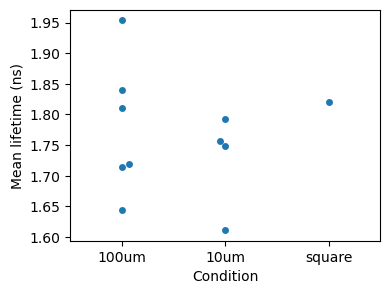

In [9]:
## Plot mean life-times per condition

fig,ax = plt.subplots(figsize=(4,3))
sns.swarmplot(x=df['Condition'],y=df['Mean lifetime (ns)'])



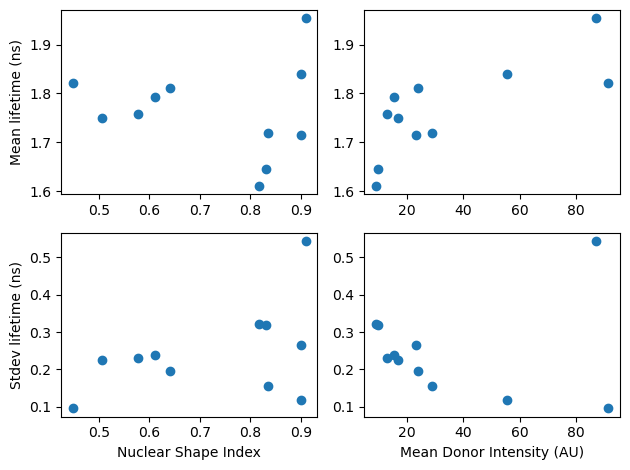

In [10]:
## Plot results

fig, axs = plt.subplots(2,2, tight_layout=True)
axs[0,0].scatter(x=df['Nuclear Shape Index'],y=df['Mean lifetime (ns)'])
axs[0,0].set_ylabel('Mean lifetime (ns)')
axs[1,0].scatter(x=df['Nuclear Shape Index'],y=df['Stdev lifetime (ns)'])
axs[1,0].set_xlabel('Nuclear Shape Index')
axs[1,0].set_ylabel('Stdev lifetime (ns)')
axs[0,1].scatter(x=df['Mean Intensity (AU)'],y=df['Mean lifetime (ns)'])
axs[1,1].scatter(x=df['Mean Intensity (AU)'],y=df['Stdev lifetime (ns)'])
axs[1,1].set_xlabel('Mean Donor Intensity (AU)')

plt.savefig(OutputFolder+'/'+date+'_figure.jpg')
plt.show()

NameError: name 'construct' is not defined

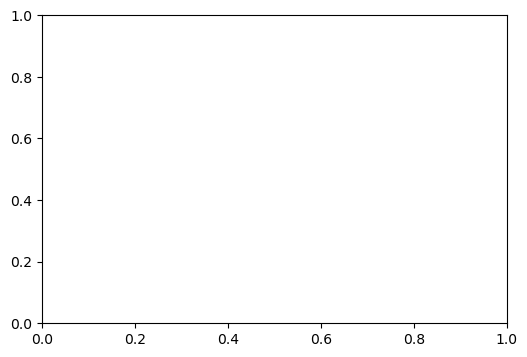

In [11]:
## Compile all histograms   
fig, ax = plt.subplots(figsize=(6,4))

histogram=[]
condition=[]

for i in range(2):
    cond = construct[i]
    hist= df.loc[df['Construct'] == cond, 'Histogram'].sum()
    ax.plot(bin_edges[0:-1], hist, label=cond)
    ax.set_xlabel('Life time (ns)', fontsize=16)
    plt.legend(frameon=False)
    
    exp.append(date)
    histogram.append(hist)
    condition.append(cond)

plt.savefig(OutputFolder+'combined_histo.tif')
plt.savefig(OutputFolder+'combined_histo.jpg')

compiled_hist = pd.DataFrame()
compiled_hist['Date'] = exp[:]
compiled_hist['Lifetime_histo'] = histogram[:]
compiled_hist['Construct'] = condition[:]

compiled_hist.to_csv(OutputFolder+'compiled_results.csv')

In [ ]:
## Compile results from different experiments

date = ['240207','240208']
df = pd.DataFrame(columns=['Date','Lifetime_histo','Construct'])

for i in range(len(date)):
    d=date[i]
    Folder = '/Users/christine/Documents/Data/DynamoLINC/FLIM/FLIM_230913/'+d+'/Results/'
    df_d = pd.read_csv(Folder+'compiled_results.csv')
    df=pd.concat([df,df_d],ignore_index=True)
    
df.to_csv('/Users/christine/Documents/Data/DynamoLINC/FLIM/'+'compiled_lifetime_histo.csv')

## Plot compiled histograms
fig, ax = plt.subplots(figsize=(6,4))

for i in range(len(df)):
    cond = df['Construct'][i]
    hist= df.loc[df['Construct'] == cond, 'Lifetime_histo'].values
    ax.plot(bin_edges[0:-1], hist, label=cond)
    ax.set_xlabel('Life time (ns)', fontsize=16)
    plt.legend(frameon=False)
    

In [ ]:
hist

---

## NE detection and FLIM analysis on NE

Here I want to 
- define a mask for the NE and analyse the lifetimes in the NE only
- for each nucleus, calculate the mean lifetime and standard deviation, and the lifetime histogram.
- concatenate results for each construct
- show the results as histograms and boxplots

In a first version, I try to segment directly on the donor image. But if levels are too heterogenous, some low expressing cells may be missed. In this case I will have to segment on FLIM image first, crop the obatined regions, then segment again on donor signal.

In [ ]:
minval = 1.3
maxval = 2.7
b=25


hist_ER = []
hist_EN = []

img_name=[]
constr=[]
nucleus=[]
mean=[]
st=[]

#acc = []
#pos = []

for i in range(2):

    h_EN = np.zeros(b)
    
    
    for j in range(9):
        f=construct[i]+'-'+str(j+1)
        
        fig, (ax0,ax1,ax2,ax3) = plt.subplots(ncols=4, figsize=(8,3),constrained_layout=True)
        #fig.suptitle(str(f))
    
    ## extract images 
        img_FLIM = io.imread(InputFolder+'FLIMdata/'+f+'.tif').astype(float)
        img_D = io.imread(InputFolder+f+'_Ch2.tif').astype(float)
        img_FRET = io.imread(InputFolder+f+'_Ch1.tif').astype(float)
        
        ax0.imshow(img_D)
        ax0.axis('off')
        ax0.set_title('Donor intensity')
        
        ax1.imshow(img_FRET)
        ax1.axis('off')
        ax1.set_title('Acceptor intensity (FRET)')
        
        ax2.imshow(img_FLIM)
        ax2.axis('off')
        ax2.set_title('Donor lifetime (ns)')
        

        # denoise
        filtered_D = ndimage.gaussian_filter(img_D, sigma=1.5)
        # binarize
        t = skimage.filters.threshold_otsu(filtered_D)
        mask = filtered_D > t
        masked_FLIM = img_FLIM*mask

        labeled_D, count = skimage.measure.label(mask, connectivity=2,return_num=True)
        #print('number of nuclei: ',count)

        props = regionprops_table(labeled_D)
        regions=pd.DataFrame(props)


        # store the bounding boxes coordinates in an array called ROIs (size = count x 4)
        ROIs = np.zeros((count,4))
        cc=0
        for p in range(count):
            
            
            minx,miny,maxx,maxy = regions.iloc[p,1:5]


            bx=(miny,maxy,maxy,miny,miny)
            by=(minx,minx,maxx,maxx,minx)
            # remove objects that are too small and count them in cc
            if maxx-minx >20 and maxy-miny>20:
                ROIs[cc] = minx,maxx,miny,maxy
                ax0.plot(bx,by)
                #print(minx)
                cc=cc+1

        # crop images around segmented NEs
        for c in range(cc):
            img_name.append(str(f))
            constr.append(construct[i])
            nucleus.append(c)
            #acc.append(acceptor[i])
            #pos.append(position[i])
            
            r=ROIs[c,:]
            minx,maxx,miny,maxy = r.astype(int)
            ROI = img_FLIM[minx:maxx,miny:maxy]
            filtered_ROI = ndimage.gaussian_filter(ROI, sigma=1.5)
            filtered_D = ndimage.gaussian_filter(img_D[minx:maxx,miny:maxy], sigma=1.5)
        
            # binarize
            t2 = skimage.filters.threshold_otsu(filtered_D)            
            mask2 = filtered_D > t2
            

    
## EN segmentation
            
            labeled_EN, count2 = skimage.measure.label(mask2, connectivity=2,return_num=True)
        
## EN lifetime 
        
            FLIM_EN = ROI*mask2
            mean.append(np.mean(FLIM_EN[FLIM_EN != 0]))
            st.append(np.std(FLIM_EN[FLIM_EN != 0]))
            histogram_EN, bin_edges = np.histogram(FLIM_EN, bins=25, range=(minval, maxval))            
            h_EN = h_EN+histogram_EN #np.concatenate((histo_EN,histogram_EN), axis=0)
            
        

            ax3.plot(bin_edges[0:-1], histogram)
            #plt.savefig('/Users/christine/Documents/Data/DynamoLINC/FLIM/Results/'+f+'_histo.tif')
            #plt.imshow(ROI)
        
            plt.savefig(OutputFolder+f+'_histo.tif')
            plt.savefig(OutputFolder+f+'_histo.jpg')
            #plt.show()
        

    
    hist_EN.append(h_EN)
                        

In [ ]:
df = pd.DataFrame()
df['Name'] = img_name[:]
df['Construct'] = constr[:]  
#df['Acceptor'] = acc[:]
#df['Position'] = pos[:]
df['Nucleus #'] = nucleus[:]
df['Mean lifetime (ns)'] = mean[:]
df['Standard deviation'] = st[:]

df.to_csv(OutputFolder+'Lifetimes_wholeCells.csv', index=False)

df                        
        

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
for i in range(2):
    ax.plot(bin_edges[0:-1], hist_EN[i], label=construct[i])
    ax.set_xlabel('Life time (ns)', fontsize=16)
    plt.legend(frameon=False)

plt.savefig(OutputFolder+'combined_histo_EN.tif')
plt.savefig(OutputFolder+'combined_histo_EN.jpg')

In [ ]:
df = pd.read_csv(OutputFolder+'Lifetimes_wholeCells.csv')
df

In [ ]:
import seaborn as sns
constr_order=['CD153','CD154','CD158','CD156']
#constr_order=['TM','CC','TM-CC1']

fig, ax = plt.subplots(figsize = (5,10))
sns.boxplot(y=df['Construct'], x=df['Mean lifetime (ns)'], data=df,order=constr_order, ax=ax )
sns.swarmplot(y=df['Construct'], x=df['Mean lifetime (ns)'], data=df, order=constr_order,color='k',legend=False, ax=ax)

plt.savefig(OutputFolder+'Boxplot.jpg')

In [ ]:
print(len(np.unique(img_name)))

In [ ]:
minval = 1.3
maxval = 2.7
b=25
construct = ['CD150','CD151','CD153','CD154','CD156','CD158']

hist_ER = []
hist_EN = []

for i in range(6):

    h_EN = np.zeros(b)
    h_ER = np.zeros(b)
    
    for j in range(10):
        f=construct[i]+'_'+str(j+1)
    
    ## extract images 
        img_FLIM = io.imread(InputFolder+'FLIMdata/'+f+'_FLIM.tif').astype(float)
        img_D = io.imread(InputFolder+f+'_Ch2.tif').astype(float)
        img_FRET = io.imread(InputFolder+f+'_Ch1.tif').astype(float)

        # denoise
        filtered_FLIM = ndimage.gaussian_filter(img_FLIM, sigma=1.5)
        # binarize
        t = skimage.filters.threshold_otsu(filtered_FLIM)
        mask = filtered_FLIM > t

        labeled_FLIM, count = skimage.measure.label(mask, connectivity=2,return_num=True)
        #print('number of nuclei: ',count)

        props = regionprops_table(labeled_FLIM)
        regions=pd.DataFrame(props)


        # store the bounding boxes coordinates in an array called ROIs (size = count x 4)
        ROIs = np.zeros((count,4))
        cc=0
        for p in range(count):
            minx,miny,maxx,maxy = regions.iloc[p,1:5]


            bx=(miny,maxy,maxy,miny,miny)
            by=(minx,minx,maxx,maxx,minx)
            if maxx-minx >30 and maxy-miny>30:
                ROIs[cc] = minx,maxx,miny,maxy
                #print(minx)
                cc=cc+1

        for c in range(cc):
            r=ROIs[c,:]
            minx,maxx,miny,maxy = r.astype(int)
            ROI = img_FLIM[minx:maxx,miny:maxy]
            filtered_ROI = ndimage.gaussian_filter(ROI, sigma=1.5)
            filtered_D = ndimage.gaussian_filter(img_D[minx:maxx,miny:maxy], sigma=1.5)
        
            # binarize
            t1 = skimage.filters.threshold_otsu(filtered_ROI)
            mask1 = ROI > t1
            #print(mask1.shape)
            t2 = skimage.filters.threshold_otsu(filtered_D)
            #print(t2)
            mask2 = filtered_D > t2
            mask3 = mask2^mask1

    
## EN and ER segmentation

            labeled_ROI, count1 = skimage.measure.label(mask1, connectivity=2,return_num=True)
            labeled_EN, count2 = skimage.measure.label(mask2, connectivity=2,return_num=True)
            labeled_ER, count3 = skimage.measure.label(mask3, connectivity=2,return_num=True)
        
## EN and ER lifetime 
        
            FLIM_ER = ROI*mask3
            FLIM_EN = ROI*mask2

            histogram_ER, bin_edges = np.histogram(FLIM_ER, bins=25, range=(minval, maxval))
            histogram_EN, bin_edges = np.histogram(FLIM_EN, bins=25, range=(minval, maxval))
        
        
            h_ER = h_ER+histogram_ER #np.concatenate((histo_ER,histogram_ER), axis=0)
            h_EN = h_EN+histogram_EN #np.concatenate((histo_EN,histogram_EN), axis=0)
            
        

            ax3.plot(bin_edges[0:-1], histogram)
            #plt.savefig('/Users/christine/Documents/Data/DynamoLINC/FLIM/Results/'+f+'_histo.tif')
            #plt.imshow(ROI)
        
            plt.savefig(OutputFolder+f+'_histo.tif')
            plt.savefig(OutputFolder+f+'_histo.jpg')
            plt.show()
        

    hist_ER.append(h_ER)
    hist_EN.append(h_EN)
    
print('Done !!')
        

In [ ]:
minval = 1.3
maxval = 2.7

b=25

h_ER = np.zeros(b)
h_EN = np.zeros(b)

for f in files:
    
## extract images 
    print(f)
    img_FLIM = io.imread(InputFolder+'FLIMdata/'+f+'_FLIM.tif').astype(float)
    img_D = io.imread(InputFolder+f+'_Ch2.tif').astype(float)
    img_FRET = io.imread(InputFolder+f+'_Ch1.tif').astype(float)
    
    # denoise
    filtered_FLIM = ndimage.gaussian_filter(img_FLIM, sigma=1.5)
    t = skimage.filters.threshold_otsu(filtered_FLIM)
    mask = filtered_FLIM > t
    labeled_FLIM, count = skimage.measure.label(mask, connectivity=2,return_num=True)
    
    #crop cells
    props = regionprops_table(labeled_FLIM)
    regions=pd.DataFrame(props)

    
    # store the bounding boxes coordinates in an array called ROIs (size = count x 4)
    ROIs = np.zeros((count,4))
    cc=0
    for p in range(count):
        minx,miny,maxx,maxy = regions.iloc[p,1:5]


        bx=(miny,maxy,maxy,miny,miny)
        by=(minx,minx,maxx,maxx,minx)
        #print(bx,by)
        if maxx-minx >20 and maxy-miny>20:
            ROIs[cc] = minx,maxx,miny,maxy
            #print(minx)
            
            cc=cc+1
    
        
    #plt.show()
    
    for i in range(cc):
        r=ROIs[i,:]
        #print(r)
        minx,maxx,miny,maxy = r.astype(int)
        ROI = img_FLIM[minx:maxx,miny:maxy]
        filtered_ROI = ndimage.gaussian_filter(ROI, sigma=1.5)
        filtered_D = ndimage.gaussian_filter(img_D[minx:maxx,miny:maxy], sigma=1.5)
        
        # binarize
        t1 = skimage.filters.threshold_otsu(filtered_ROI)
        mask1 = ROI > t1
        #print(mask1.shape)
        t2 = skimage.filters.threshold_otsu(filtered_D)
        #print(t2)
        mask2 = filtered_D > t2
        mask3 = mask2^mask1

    
## EN and ER segmentation

        labeled_ROI, count1 = skimage.measure.label(mask1, connectivity=2,return_num=True)
        labeled_EN, count2 = skimage.measure.label(mask2, connectivity=2,return_num=True)
        labeled_ER, count3 = skimage.measure.label(mask3, connectivity=2,return_num=True)
        
## EN and ER lifetime 
        
        FLIM_ER = ROI*mask3
        FLIM_EN = ROI*mask2
        
        histogram_ER, bin_edges = np.histogram(FLIM_ER, bins=25, range=(minval, maxval))
        histogram_EN, bin_edges = np.histogram(FLIM_EN, bins=25, range=(minval, maxval))
        
        if 'CD153' in f:
            hClo_ER = hClo_ER+histogram_ER #np.concatenate((histo_ER,histogram_ER), axis=0)
            hClo_EN = hClo_EN+histogram_EN #np.concatenate((histo_EN,histogram_EN), axis=0)
            
        else:
            hFS_ER = hClo_ER+histogram_ER #np.concatenate((histo_ER,histogram_ER), axis=0)
            hFS_EN = hClo_EN+histogram_EN #np.concatenate((histo_EN,histogram_EN), axis=0)

## representation

        fig, (ax0,ax1,ax2,ax3) = plt.subplots(ncols=4, figsize=(16,6),constrained_layout=True)
        flim=ax0.imshow(ROI)
        fig.colorbar(flim, ax=ax0, shrink = 0.7)
        ax0.axis('off')
        ax0.set_title('FLIM',fontsize=20)

        en=ax1.imshow(FLIM_EN, cmap='viridis')
        fig.colorbar(en, ax=ax1, shrink = 0.7)
        ax1.axis('off')
        ax1.set_title('EN',fontsize=20)

        er= ax2.imshow(FLIM_ER, cmap='viridis')
        fig.colorbar(er, ax=ax2, shrink = 0.7)
        ax2.axis('off')
        ax2.set_title('ER',fontsize=20)
        
        ax3.plot(bin_edges[0:-1],histogram_EN, label = 'EN',color='darkviolet', linewidth=3)
        ax3.plot(bin_edges[0:-1],histogram_ER, label = 'ER', color='mediumseagreen',linewidth=3)
        ax3.legend(frameon=False, fontsize=16)
        fig.suptitle(f, fontsize=32)
        
        
        plt.savefig(OutputFolder+f+'_'+str(i)+'ER_EN.tif')
        plt.savefig(OutputFolder+f+'_'+str(i)+'ER_EN.jpg')

        
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.plot(bin_edges[0:-1],hClo_ER, label='ER', color='mediumseagreen')
ax0.plot(bin_edges[0:-1],hClo_EN, label='EN', color='darkviolet')
ax0.set_title('Clover only')
ax0.legend(frameon=False)
ax1.plot(bin_edges[0:-1],hFS_ER, label='ER',color='mediumseagreen')
ax1.plot(bin_edges[0:-1],hFS_EN, label='EN',color='darkviolet')
ax1.set_title('Force Sensor')
ax1.legend(frameon=False)
ax1.set_xlabel('Life time (ns)')

plt.savefig(OutputFolder+'combined_ER_EN_histograms.tif')
plt.savefig(OutputFolder+'combined_ER_EN_histograms.jpg')

In [ ]:
    
## FLIM analysis  
    
    props = regionprops_table(labeled_FLIM)
    regions=pd.DataFrame(props)
    
    # store the bounding boxes coordinates in an array called ROIs (size = count x 4)
    ROIs = np.zeros((count,4))
    cc=0
    for p in range(count):
        minx,miny,maxx,maxy = regions.iloc[p,1:5]


        bx=(miny,maxy,maxy,miny,miny)
        by=(minx,minx,maxx,maxx,minx)
        if maxx-minx >20 and maxy-miny>20:
            ROIs[cc] = minx,maxx,miny,maxy
            #print(minx)
            ax0.plot(bx,by)
            ax1.plot(bx,by)
            ax2.plot(bx,by)
            cc=cc+1
    
        
    #plt.show()
    
    for i in range(cc):
        r=ROIs[i,:]
        minx,maxx,miny,maxy = r.astype(int)
        ROI = img_FLIM[minx:maxx,miny:maxy]
        #print(ROI.shape)
        histogram, bin_edges = np.histogram(ROI, bins=25, range=(minval, maxval))
        #print(bin_edges[0:-1])
        
        ax3.plot(bin_edges[0:-1], histogram)
        #plt.savefig('/Users/christine/Documents/Data/DynamoLINC/FLIM/Results/'+f+'_histo.tif')
        #plt.imshow(ROI)
    #plt.savefig(OutputFolder+f+'_histo.tif')        
plt.show()